In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) Read CSV, parse Date and set as index in one go
path = r"C:\Users\Vai.Mathi\Downloads\SPX.csv\SPX.csv"
df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')

# 2) Slice 2019 and force a copy to safely modify
df_2019 = df.loc['2019-01-01':'2019-12-31'].copy()

# 3) Add the Open_T_plus_1 column
df_2019['Next Day Open'] = df_2019['Open'].shift(-1)

# 4) Drop the last row (it has no T+1) 
df_2019.dropna(subset=['Next Day Open'], inplace=True)

# Check
print(df_2019.shape)
df_2019.head()





(251, 7)


Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-02  2476.959961  2519.489990  2467.469971  2510.030029  2510.030029   
2019-01-03  2491.919922  2493.139893  2443.959961  2447.889893  2447.889893   
2019-01-04  2474.330078  2538.070068  2474.330078  2531.939941  2531.939941   
2019-01-07  2535.610107  2566.159912  2524.560059  2549.689941  2549.689941   
2019-01-08  2568.110107  2579.820068  2547.560059  2574.409912  2574.409912   

                Volume  Next Day Open  
Date                                   
2019-01-02  3733160000    2491.919922  
2019-01-03  3822860000    2474.330078  
2019-01-04  4213410000    2535.610107  
2019-01-07  4104710000    2568.110107  
2019-01-08  4083030000    2580.000000

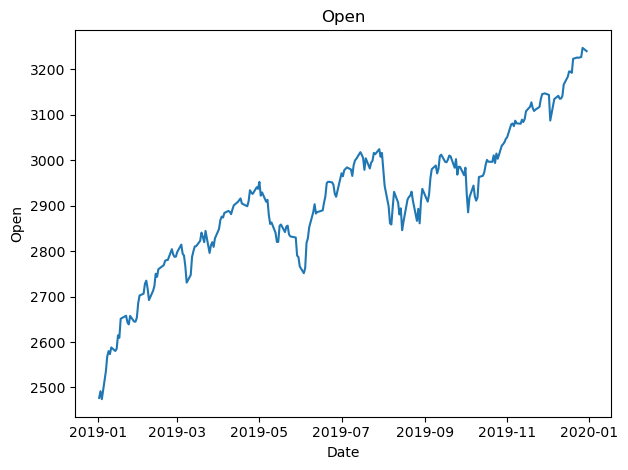

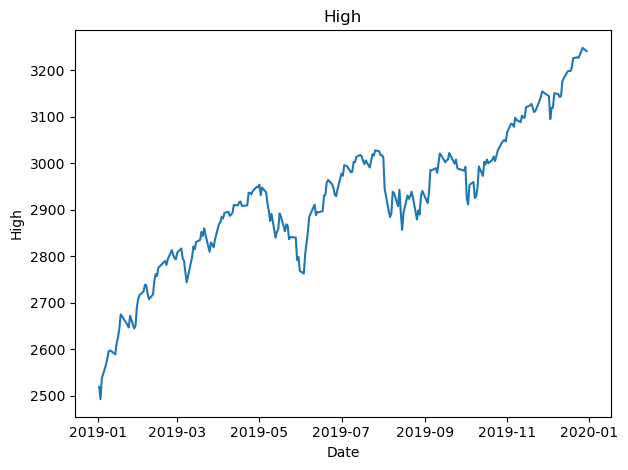

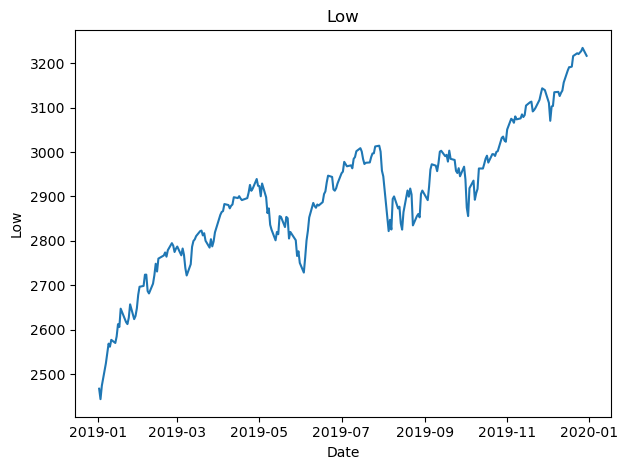

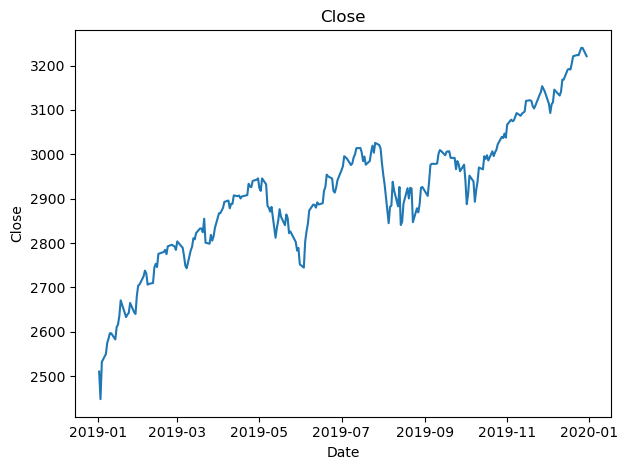

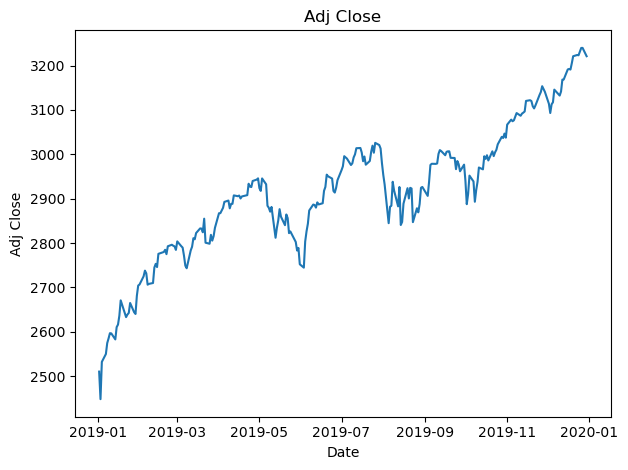

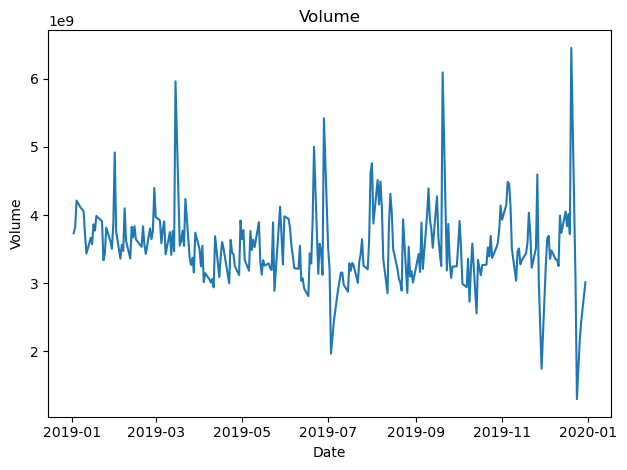

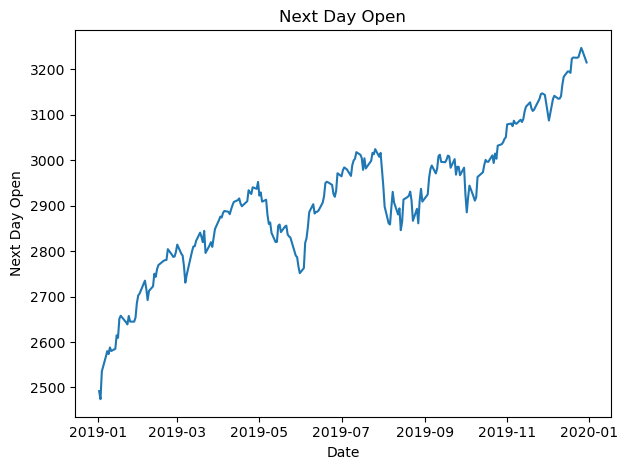

In [36]:


# if you haven’t already:
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
# df_2019 = df.loc['2019-01-01':'2019-12-31']

for col in df_2019.columns:
    plt.figure()
    plt.plot(df_2019.index, df_2019[col])
    plt.title(col)
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.997596  0.996276  0.993810   0.993810 -0.156749
High       0.997596  1.000000  0.996447  0.997131   0.997131 -0.153360
Low        0.996276  0.996447  1.000000  0.997695   0.997695 -0.174212
Close      0.993810  0.997131  0.997695  1.000000   1.000000 -0.168759
Adj Close  0.993810  0.997131  0.997695  1.000000   1.000000 -0.168759
Volume    -0.156749 -0.153360 -0.174212 -0.168759  -0.168759  1.000000


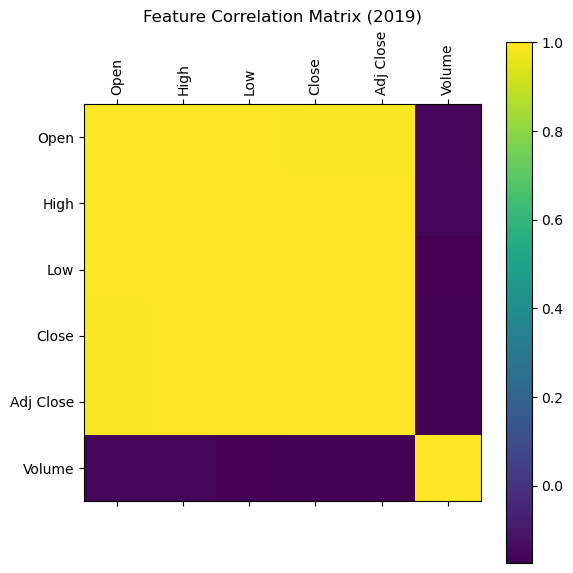

In [37]:

# 1) Grab only the feature columns (everything except your target)
features = df_2019.drop(columns=['Next Day Open'])

# 2) Compute the Pearson correlation matrix
corr = features.corr()

# 3) (Optional) print the raw numbers
print(corr)

# 4) (Optional) visualize as a heatmap with matplotlib
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(corr)              # color‐coded matrix
fig.colorbar(cax)                   # legend bar
ticks = range(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Feature Correlation Matrix (2019)")
plt.tight_layout()
plt.show()


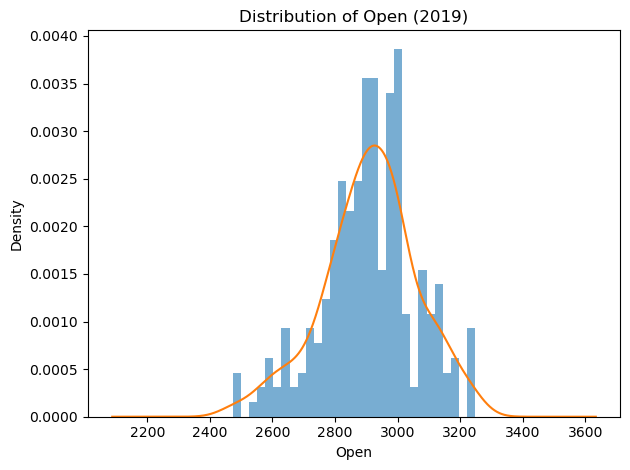

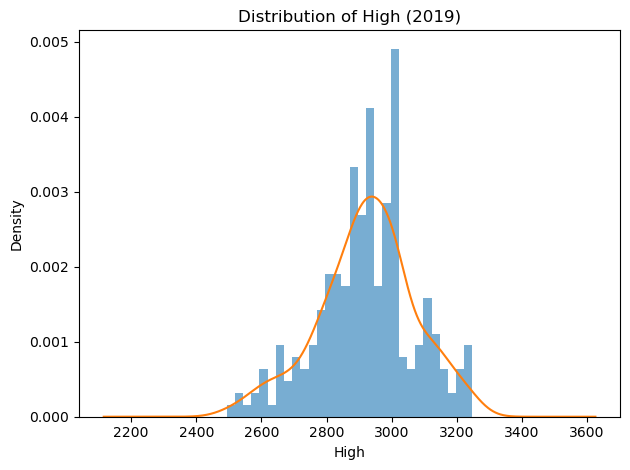

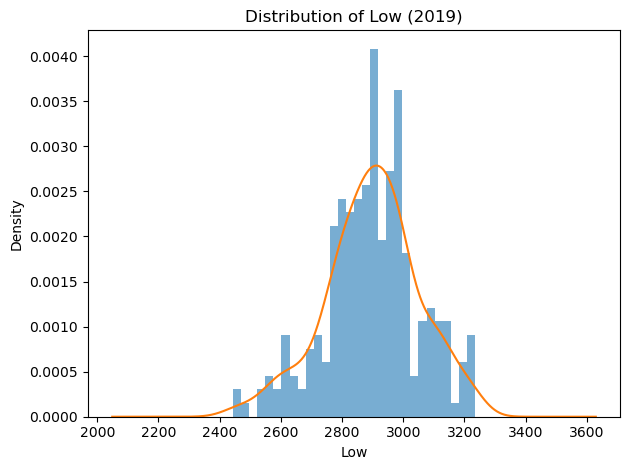

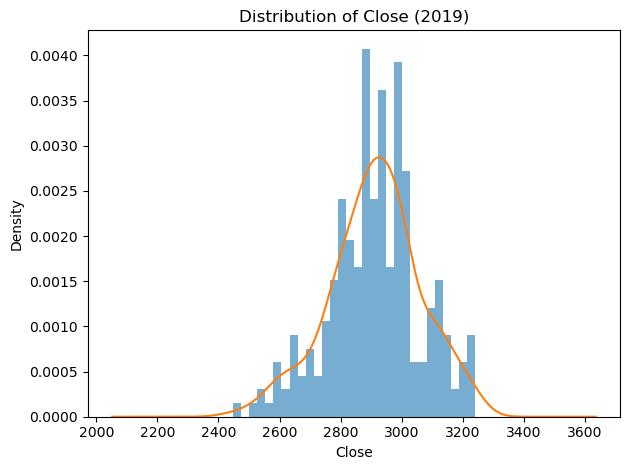

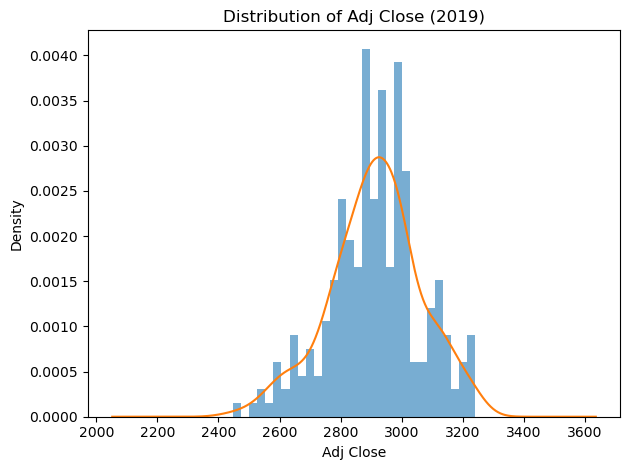

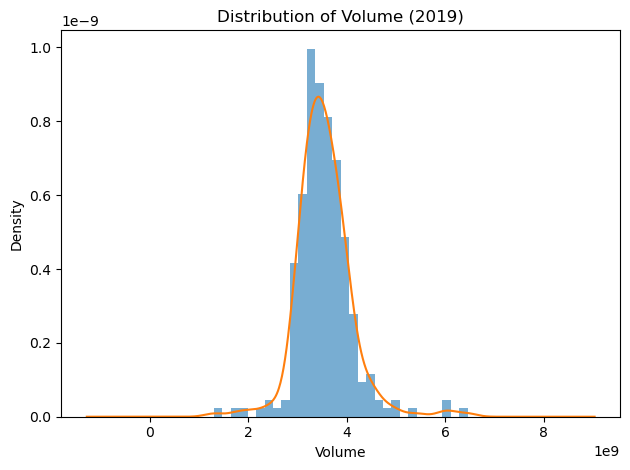

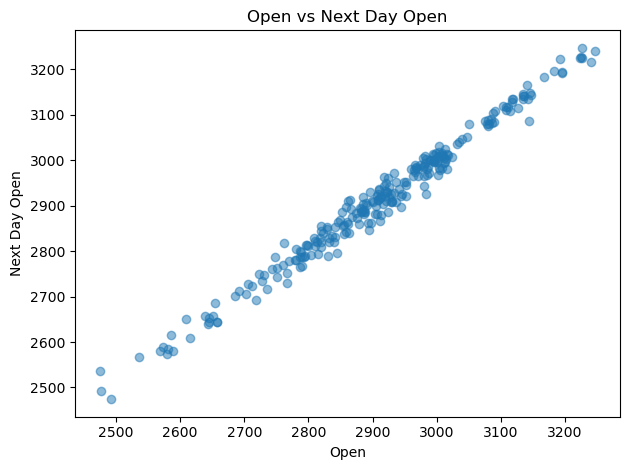

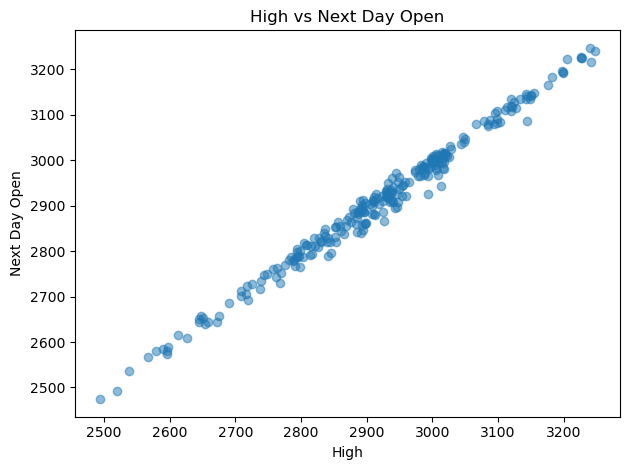

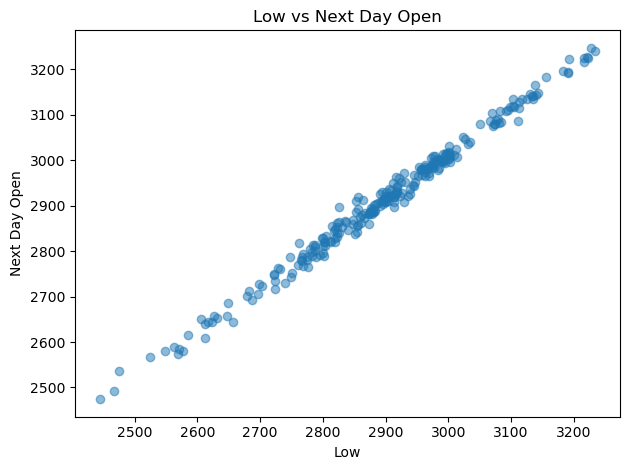

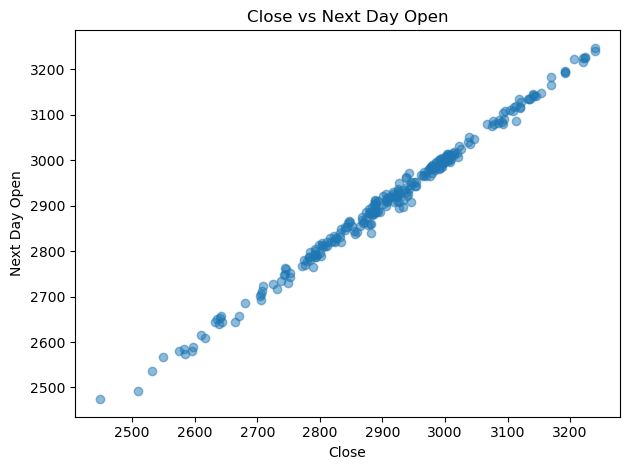

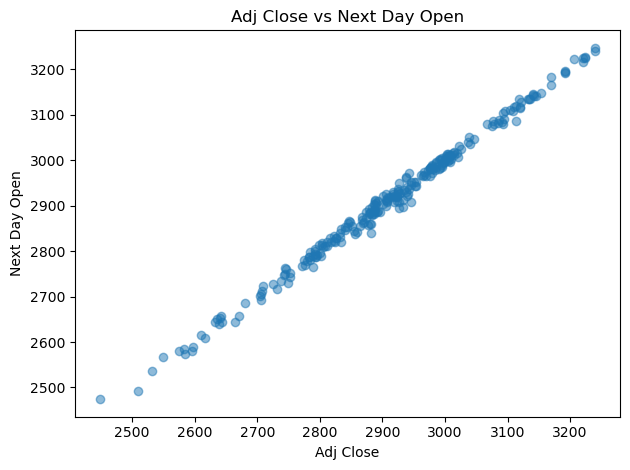

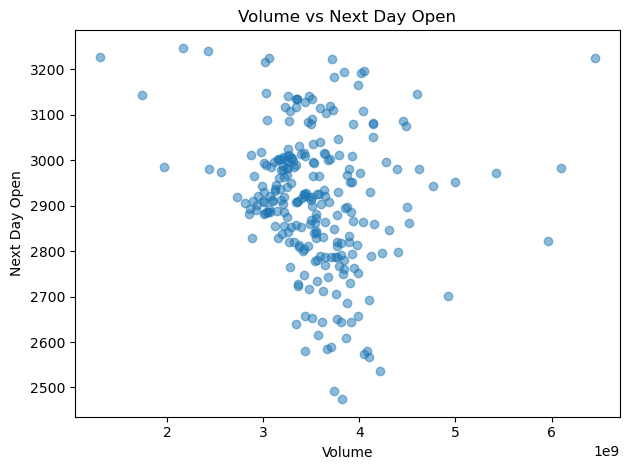

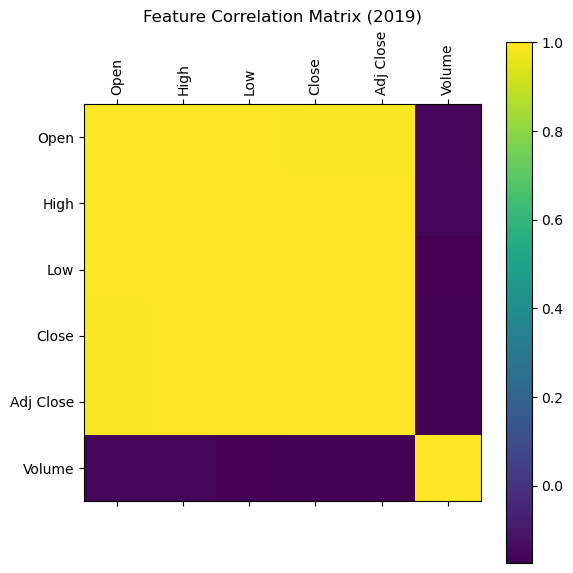

Explained variance ratio: [0.83677298 0.16112046]


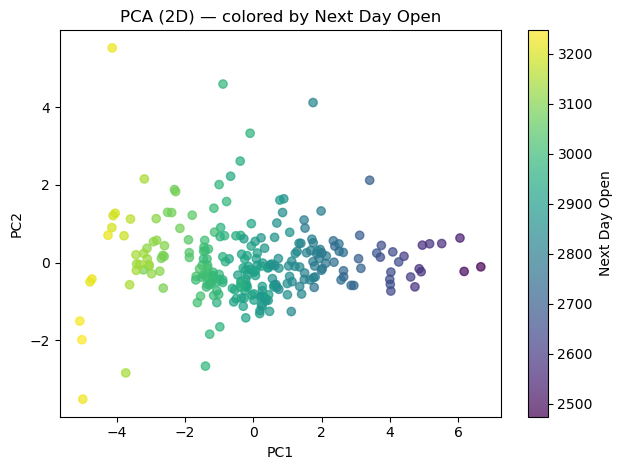

C:\Users\Vai.Mathi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


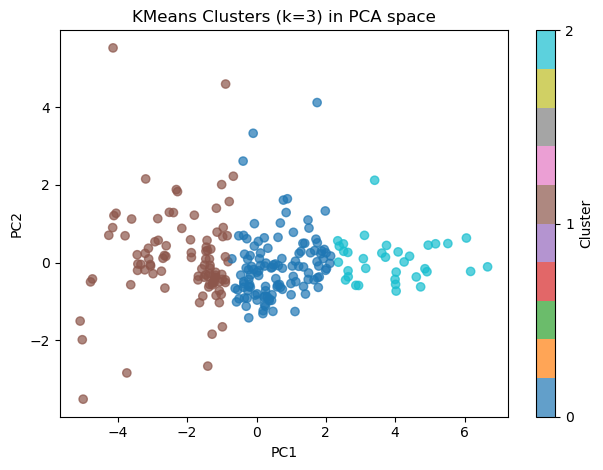

In [38]:

# 1) Split out features vs. target
features = df_2019.drop(columns=['Next Day Open'])
target   = df_2019['Next Day Open']

# 2) Plot individual feature distributions (hist + KDE)
for col in features.columns:
    plt.figure()
    ax = features[col].hist(bins=30, density=True, alpha=0.6)
    features[col].plot(kind='kde', ax=ax)
    plt.title(f'Distribution of {col} (2019)')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# 3) Scatter each feature vs. target
for col in features.columns:
    plt.figure()
    plt.scatter(features[col], target, alpha=0.5)
    plt.title(f'{col} vs Next Day Open')
    plt.xlabel(col)
    plt.ylabel('Next Day Open')
    plt.tight_layout()
    plt.show()

# 4) Compute & plot Pearson correlation matrix
corr = features.corr()
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(corr)
fig.colorbar(cax)
ticks = range(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title('Feature Correlation Matrix (2019)')
plt.tight_layout()
plt.show()

# 5) Standardize features and run PCA → 2 components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 6) Scatter PCA colored by Next Day Open (continuous)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=target, cmap='viridis', alpha=0.7)
plt.colorbar(label='Next Day Open')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2D) — colored by Next Day Open')
plt.tight_layout()
plt.show()

# 7) K-means clustering in the scaled feature space
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(ticks=range(3), label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clusters (k=3) in PCA space')
plt.tight_layout()
plt.show()
